In [92]:
import pickle
from typing import NamedTuple, Callable, List 
from src.custom_types import Simulation, FittedModel, MLDataSets, Trajectory
from src.io_utils import load_ala2_dataset, lagged_dataset
from kooplearn.estimators import LowRankRegressor
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'std-colors'])
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
import numpy as np
from numpy.typing import NDArray
from einops import einsum

In [93]:
#Helper Structs
class Estimator(NamedTuple):
    num_samples: NDArray
    op_norm_error: NDArray
    metric_distortion: NDArray
    eigenvalues: NDArray
    right_eigenfunctions: List[Callable]
    fitted_estimator: List[LowRankRegressor]

class EstimatorComparison(NamedTuple):
    PCR: Estimator
    RRR: Estimator

def load_estimator_data(file_path: str) -> Estimator:
    with open(file_path, 'rb') as f:
        _simulation = pickle.load(f)
    num_samples = np.sort(np.asarray(list(_simulation.training_points.keys())))
    op_norm_error = np.asarray([_simulation.training_points[n].operator_norm_error for n in num_samples])
    metric_distortion = np.array([_simulation.training_points[n].metric_distortion for n in num_samples]).T
    eigenvalues = np.array([_simulation.training_points[n].eigenvalues for n in num_samples]).real
    rf = [_simulation.training_points[n].fitted_estimator.eig()[1] for n in num_samples]
    estimators = [_simulation.training_points[n].fitted_estimator for n in num_samples]
    return Estimator(num_samples, op_norm_error, metric_distortion, eigenvalues, rf, estimators)


## Results analysis

In [94]:
results = EstimatorComparison(
    load_estimator_data('../data/eigenvalue_estimation/PCR_1529_23_1_23.pkl'),
    load_estimator_data('../data/eigenvalue_estimation/RRR_1528_23_1_23.pkl')
)

### Operator norm risk

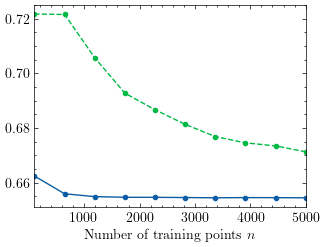

In [95]:
fig, ax = plt.subplots()

plot_configs = {
    'xlabel': r"Number of training points $n$",
}
ax.plot(
    results.PCR.num_samples, 
    (results.PCR.op_norm_error), 
    '.-', label='PCR')
ax.plot(
    results.RRR.num_samples, 
    results.RRR.op_norm_error, 
    '.--', label='RRR')

ax.set(**plot_configs)
ax.margins(x=0)
#ax.legend()

### Eigenfunctions

In [87]:
#Validation data
data = load_ala2_dataset("../data")
X_test, Y_test = lagged_dataset(data.test.distances, lagtime = 50)

In [88]:
L2_RRR_eval_X = [
    results.RRR.right_eigenfunctions[n](X_test)
    for n in range(len(results.RRR.num_samples))
]

L2_PCR_eval_X = [
    results.PCR.right_eigenfunctions[n](X_test)
    for n in range(len(results.PCR.num_samples))
]

L2_RRR_eval_Y = [
    results.RRR.right_eigenfunctions[n](Y_test)
    for n in range(len(results.RRR.num_samples))
]

L2_PCR_eval_Y = [
    results.PCR.right_eigenfunctions[n](Y_test)
    for n in range(len(results.PCR.num_samples))
]

In [89]:
L2_RRR_norm = (X_test.shape[0]**(-0.5))*np.array([np.sqrt(np.sum(f*f.conj(), axis=0)) for f in L2_RRR_eval_X])
L2_PCR_norm = (X_test.shape[0]**(-0.5))*np.array([np.sqrt(np.sum(f*f.conj(), axis=0)) for f in L2_PCR_eval_X])
L2_diff = []
for i in range(len(L2_RRR_eval_X)):
    L2_diff.append(
        L2_RRR_eval_X[i]/L2_RRR_norm[i] - L2_PCR_eval_X[i]/L2_RRR_norm[i]
        )
L2_dist = (X_test.shape[0]**(-0.5))*np.array([np.sqrt(np.sum(f*f.conj(), axis=0)) for f in L2_diff])

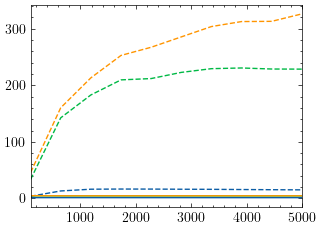

In [91]:
fig, ax = plt.subplots()
for idx in range(3):
    ax.plot(results.PCR.num_samples, (L2_PCR_norm.real**-1)[:, idx], color=colors[idx]);
    ax.plot(results.RRR.num_samples, (L2_RRR_norm.real**-1)[:, idx], '--', color=colors[idx]);
ax.margins(x=0)

### Eigenvalue equation score

In [96]:
RRR_eigenvalue_eq = []
for idx in range(len(L2_RRR_eval_X)):
    f_X = L2_RRR_eval_X[idx]
    f_Y = L2_RRR_eval_Y[idx]
    evals = (results.RRR.eigenvalues)[idx]
    d = (f_Y - f_X*evals)/L2_RRR_norm[idx]
    RRR_eigenvalue_eq.append((X_test.shape[0]**(-0.5))*np.sqrt(np.sum(d*d.conj(), axis=0)).real)

PCR_eigenvalue_eq = []
for idx in range(len(L2_PCR_eval_X)):
    f_X = L2_PCR_eval_X[idx]
    f_Y = L2_PCR_eval_Y[idx]
    evals = (results.RRR.eigenvalues)[idx]
    d = (f_Y - f_X*evals)/L2_PCR_norm[idx]
    PCR_eigenvalue_eq.append((X_test.shape[0]**(-0.5))*np.sqrt(np.sum(d*d.conj(), axis=0)).real)

RRR_eigenvalue_eq = np.array(RRR_eigenvalue_eq)
PCR_eigenvalue_eq = np.array(PCR_eigenvalue_eq)

[None]

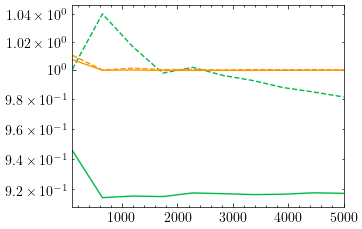

In [99]:
fig, ax = plt.subplots()
for idx in range(1,3):
    ax.plot(results.PCR.num_samples, PCR_eigenvalue_eq[:, idx], color=colors[idx]);
    ax.plot(results.RRR.num_samples, RRR_eigenvalue_eq[:, idx], '--', color=colors[idx]);
ax.margins(x=0)
ax.set(yscale='log')

### Covariance singular values

The metric distortions seems to scale with the number of training points. Check if this is an error.

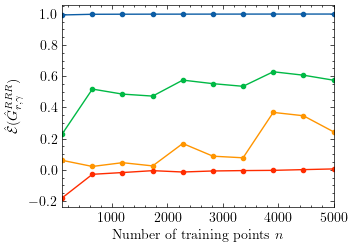

In [28]:
fig, ax = plt.subplots()
plot_configs = {
    'xlabel': r"Number of training points $n$",
    'ylabel': r"$\hat{\mathcal{E}}(\hat{G}^{RRR}_{r, \gamma})$",
}
ax.plot(training_points, evals.real, '.-')
ax.set(**plot_configs)
ax.margins(x=0)